# Modelado Predictivo de Éxito Comercial en Videojuegos: Del 'Hype' a las Ventas

## Introducción

Este notebook tiene como objetivo predecir las ventas globales de videojuegos (`Global_Sales`) mediante técnicas de machine learning. La particularidad de este análisis es que unificamos las ventas multiplataforma agrupando por juego, lo que nos permite entender el rendimiento real de una IP (propiedad intelectual) independientemente de la plataforma en la que se comercialice.

Utilizaremos **Gradient Boosting** como algoritmo principal, una técnica de ensemble learning que combina múltiples modelos débiles para crear un predictor robusto capaz de capturar relaciones no lineales complejas entre las características y las ventas.


## Preguntas e Hipótesis

Antes de comenzar el modelado, planteamos tres preguntas clave que guiarán nuestro análisis:

1. **¿El "Buzz" (volumen de críticas) predice mejor que la calidad (Score)?**
   - Hipótesis: El volumen de interacciones (cantidad de críticas y reseñas) puede ser un mejor predictor del éxito comercial que las puntuaciones promedio, ya que refleja el nivel de atención y discusión generada por el juego.

2. **¿Cuánto influye el Publisher (quien pone el dinero) vs el Developer?**
   - Hipótesis: El Publisher, responsable del marketing y distribución, podría tener un impacto mayor en las ventas que el Developer, quien se enfoca en el desarrollo técnico.

3. **¿Cómo afecta la antigüedad del juego (Game_Age)?**
   - Hipótesis: Los juegos más antiguos pueden tener ventas acumuladas diferentes a los nuevos, y la edad del juego podría ser un factor relevante en el modelo predictivo.


In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# ===== CONFIGURACIÓN GLOBAL =====
RANDOM_STATE = 42  # Seed para reproducibilidad

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [2]:
# Carga del dataset
df = pd.read_csv('data/global_videogames_sales_2023.csv')

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
df.head()


Dimensiones del dataset: (6894, 18)

Primeras filas:


,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Story Focus,Gameplay Focus,Series
0,.hack//Infection Part 1,2002.0,Role-Playing,Atari,0.49,0.38,0.26,0.13,1.27,75.0,35.0,8.5,60.0,CyberConnect2,T,x,NaN,x
1,.hack//Mutation Part 2,2002.0,Role-Playing,Atari,0.23,0.18,0.20,0.06,0.68,76.0,24.0,8.9,81.0,CyberConnect2,T,x,NaN,x
2,.hack//Outbreak Part 3,2002.0,Role-Playing,Atari,0.14,0.11,0.17,0.04,0.46,70.0,23.0,8.7,19.0,CyberConnect2,T,x,NaN,x
3,[Prototype],2009.0,Action,Activision,0.84,0.35,0.00,0.12,1.31,78.0,83.0,7.8,356.0,Radical Entertainment,M,NaN,x,x
4,[Prototype],2009.0,Action,Activision,0.65,0.40,0.00,0.19,1.24,79.0,53.0,7.7,308.0,Radical Entertainment,M,NaN,x,x


In [3]:
# Información general del dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6894 entries, 0 to 6893
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             6894 non-null   object 
 1   Year_of_Release  6894 non-null   float64
 2   Genre            6894 non-null   object 
 3   Publisher        6893 non-null   object 
 4   NA_Sales         6894 non-null   float64
 5   EU_Sales         6894 non-null   float64
 6   JP_Sales         6894 non-null   float64
 7   Other_Sales      6894 non-null   float64
 8   Global_Sales     6894 non-null   float64
 9   Critic_Score     6894 non-null   float64
 10  Critic_Count     6894 non-null   float64
 11  User_Score       6894 non-null   float64
 12  User_Count       6894 non-null   float64
 13  Developer        6890 non-null   object 
 14  Rating           6826 non-null   object 
 15  Story Focus      767 non-null    object 
 16  Gameplay Focus   6586 non-null   object 
 17  Series        

In [4]:
# Limpieza básica de datos
# Convertir User_Score a float (si es necesario)
if 'User_Score' in df.columns:
    # Reemplazar valores no numéricos o strings
    df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')

# Convertir columnas binarias 'x' a 1/0
for col in df.columns:
    if df[col].dtype == 'object':
        # Verificar si la columna contiene solo 'x' o valores binarios
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) <= 2 and 'x' in [str(v).lower() for v in unique_vals]:
            df[col] = (df[col].astype(str).str.lower() == 'x').astype(int)

print("Limpieza completada")
print(f"Valores nulos por columna:\n{df.isnull().sum()}")


Limpieza completada
Valores nulos por columna:
Name                0
Year_of_Release     0
Genre               0
Publisher           1
NA_Sales            0
EU_Sales            0
JP_Sales            0
Other_Sales         0
Global_Sales        0
Critic_Score        0
Critic_Count        0
User_Score          0
User_Count          0
Developer           4
Rating             68
Story Focus         0
Gameplay Focus      0
Series              0
dtype: int64


## Agrupación por Nombre de Juego (Wrangling Avanzado)

Agrupamos el dataframe por `Name` para fusionar las ventas de diferentes plataformas (PS3, Xbox, PC, etc.) y obtener el rendimiento total de cada IP.


In [5]:
# Agrupación por Name para unificar ventas multiplataforma
# Lógica de agregación:
# - Sumar: Global_Sales, Critic_Count, User_Count
# - Promediar: Critic_Score, User_Score
# - Tomar el primero/máximo de los demás

agg_dict = {}

# Columnas a sumar
if 'Global_Sales' in df.columns:
    agg_dict['Global_Sales'] = 'sum'
if 'Critic_Count' in df.columns:
    agg_dict['Critic_Count'] = 'sum'
if 'User_Count' in df.columns:
    agg_dict['User_Count'] = 'sum'

# Columnas a promediar
if 'Critic_Score' in df.columns:
    agg_dict['Critic_Score'] = 'mean'
if 'User_Score' in df.columns:
    agg_dict['User_Score'] = 'mean'

# Para las demás columnas, tomar el primero (asumiendo que son constantes por juego)
other_cols = [col for col in df.columns if col not in agg_dict.keys() and col != 'Name']
for col in other_cols:
    if df[col].dtype in ['int64', 'float64']:
        agg_dict[col] = 'first'
    else:
        agg_dict[col] = 'first'

# Agrupar
df_grouped = df.groupby('Name', as_index=False).agg(agg_dict)

print(f"Filas originales: {len(df)}")
print(f"Filas después de agrupar: {len(df_grouped)}")
print(f"\nPrimeras filas agrupadas:")
df_grouped.head()


Filas originales: 6894
Filas después de agrupar: 4424

Primeras filas agrupadas:


,Name,Global_Sales,Critic_Count,User_Count,Critic_Score,User_Score,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Developer,Rating,Story Focus,Gameplay Focus,Series
0,.hack//Infection Part 1,1.27,35.0,60.0,75.0,8.500,2002.0,Role-Playing,Atari,0.49,0.38,0.26,0.13,CyberConnect2,T,1,0,1
1,.hack//Mutation Part 2,0.68,24.0,81.0,76.0,8.900,2002.0,Role-Playing,Atari,0.23,0.18,0.20,0.06,CyberConnect2,T,1,0,1
2,.hack//Outbreak Part 3,0.46,23.0,19.0,70.0,8.700,2002.0,Role-Playing,Atari,0.14,0.11,0.17,0.04,CyberConnect2,T,1,0,1
3,007 Racing,0.53,16.0,14.0,51.0,4.600,2000.0,Racing,Electronic Arts,0.30,0.20,0.00,0.03,Eutechnyx,T,0,1,0
4,007: Quantum of Solace,3.30,140.0,199.0,63.5,6.875,2008.0,Action,Activision,0.82,0.51,0.01,0.14,Treyarch,T,0,1,0


In [6]:
# Imputación de nulos en Scores usando la mediana del Genre
if 'Critic_Score' in df_grouped.columns and 'Genre' in df_grouped.columns:
    df_grouped['Critic_Score'] = df_grouped.groupby('Genre')['Critic_Score'].transform(
        lambda x: x.fillna(x.median())
    )
    # Si aún hay nulos (géneros sin datos), usar mediana global
    df_grouped['Critic_Score'] = df_grouped['Critic_Score'].fillna(df_grouped['Critic_Score'].median())

if 'User_Score' in df_grouped.columns and 'Genre' in df_grouped.columns:
    df_grouped['User_Score'] = df_grouped.groupby('Genre')['User_Score'].transform(
        lambda x: x.fillna(x.median())
    )
    df_grouped['User_Score'] = df_grouped['User_Score'].fillna(df_grouped['User_Score'].median())

print("Imputación completada")
print(f"Valores nulos restantes:\n{df_grouped.isnull().sum().sum()}")


Imputación completada
Valores nulos restantes:
52


## Feature Engineering

Creamos nuevas variables que capturan relaciones más complejas y relevantes para la predicción.


In [7]:
# Feature Engineering

# 1. Game_Age: Antigüedad del juego
if 'Year_of_Release' in df_grouped.columns:
    df_grouped['Game_Age'] = 2023 - df_grouped['Year_of_Release']
    # Manejar valores nulos o inválidos
    df_grouped['Game_Age'] = df_grouped['Game_Age'].fillna(df_grouped['Game_Age'].median())

# 2. Score_Diff: Diferencia entre críticos y usuarios
if 'Critic_Score' in df_grouped.columns and 'User_Score' in df_grouped.columns:
    # User_Score típicamente está en escala 0-10, Critic_Score en 0-100
    df_grouped['Score_Diff'] = df_grouped['Critic_Score'] - (df_grouped['User_Score'] * 10)

# 3. Variables Buzz: Combinan Score con Count
if 'Critic_Score' in df_grouped.columns and 'Critic_Count' in df_grouped.columns:
    df_grouped['Critic_Buzz'] = df_grouped['Critic_Score'] * df_grouped['Critic_Count']

if 'User_Score' in df_grouped.columns and 'User_Count' in df_grouped.columns:
    df_grouped['User_Buzz'] = df_grouped['User_Score'] * df_grouped['User_Count']

print("Feature Engineering completado")
print(f"\nNuevas columnas creadas:")
new_cols = ['Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz']
for col in new_cols:
    if col in df_grouped.columns:
        print(f"  - {col}")


Feature Engineering completado

Nuevas columnas creadas:
  - Game_Age
  - Score_Diff
  - Critic_Buzz
  - User_Buzz


In [8]:
# Agrupación de categorías: Top 20 para Developer y Publisher
# Mantener Top 20 y etiquetar el resto como 'Other'

for col in ['Developer', 'Publisher']:
    if col in df_grouped.columns:
        # Contar frecuencias
        top_values = df_grouped[col].value_counts().head(20).index.tolist()
        # Reemplazar valores no top con 'Other'
        df_grouped[col] = df_grouped[col].apply(
            lambda x: x if x in top_values else 'Other'
        )
        print(f"{col}: {len(top_values)} categorías principales + 'Other'")

print("\nAgrupación de categorías completada")


Developer: 20 categorías principales + 'Other'
Publisher: 20 categorías principales + 'Other'

Agrupación de categorías completada


## Preparación de Datos y Split Train/Test


In [9]:
# Definir features y target
# IMPORTANTE: Definir explícitamente las features para evitar Data Leakage
# No usar ventas regionales (NA_Sales, EU_Sales, JP_Sales, Other_Sales) 
# porque son parte del target y no están disponibles pre-lanzamiento

# Definir features explícitas (Evitar Leakage de ventas regionales)
features_to_use = [
    # Numéricas
    'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
    'Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz',
    # Categóricas (que ya fueron procesadas/agrupadas o binarias)
    'Genre', 'Rating', 'Developer', 'Publisher', 
    'Story Focus', 'Gameplay Focus', 'Series'
]

# Asegurarse de que solo usamos columnas que existen en el df_grouped
valid_features = [col for col in features_to_use if col in df_grouped.columns]

print(f"Features seleccionadas: {len(valid_features)}")
print(f"Features válidas: {valid_features}")

# Separar features numéricas y categóricas para el encoding
numeric_features = []
categorical_features = []

for col in valid_features:
    if df_grouped[col].dtype in ['int64', 'float64']:
        numeric_features.append(col)
    elif df_grouped[col].dtype == 'object':
        categorical_features.append(col)

print(f"\nFeatures numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")

# Crear X solo con estas columnas
X = df_grouped[valid_features].copy()
y = df_grouped['Global_Sales'].copy()

# Eliminar filas con target nulo
mask = y.notna()
X = X[mask].copy()
y = y[mask].copy()

print(f"\nFilas válidas: {len(X)}")


Features seleccionadas: 15
Features válidas: ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Game_Age', 'Score_Diff', 'Critic_Buzz', 'User_Buzz', 'Genre', 'Rating', 'Developer', 'Publisher', 'Story Focus', 'Gameplay Focus', 'Series']

Features numéricas: 11
Features categóricas: 4

Filas válidas: 4424


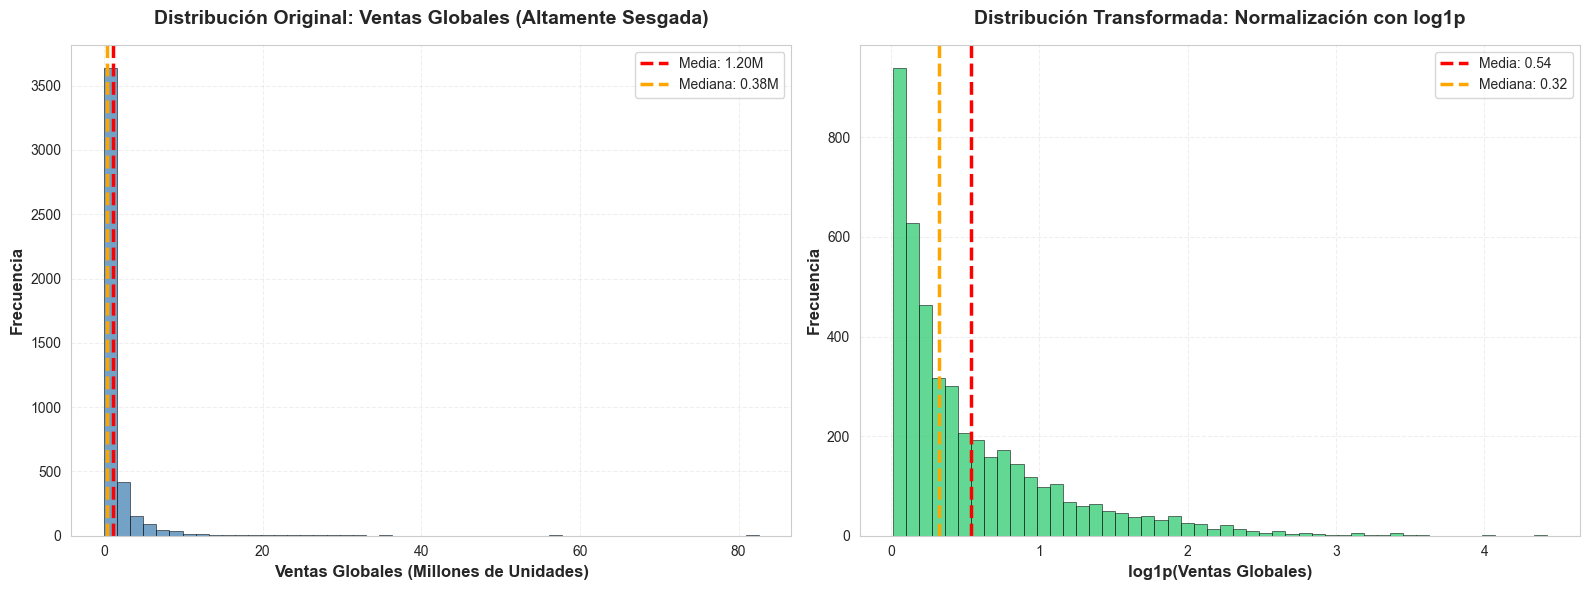

ESTADÍSTICAS DE LA TRANSFORMACIÓN
Distribución Original:
  Media: 1.20 millones
  Mediana: 0.38 millones
  Desviación Estándar: 2.88 millones
  Asimetría: 10.59

Distribución Transformada (log1p):
  Media: 0.54
  Mediana: 0.32
  Desviación Estándar: 0.58
  Asimetría: 1.80


In [10]:
# Aplicar log1p al target para normalizar la distribución
y_log = np.log1p(y)

# Transformación de la Distribución del Target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== GRÁFICO 1: Distribución Original =====
# Histograma con estilo mejorado
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.75, 
              color='steelblue', linewidth=0.5)
axes[0].axvline(y.mean(), color='red', linestyle='--', lw=2.5, 
                label=f'Media: {y.mean():.2f}M')
axes[0].axvline(y.median(), color='orange', linestyle='--', lw=2.5, 
                label=f'Mediana: {y.median():.2f}M')

axes[0].set_title('Distribución Original: Ventas Globales (Altamente Sesgada)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Ventas Globales (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# ===== GRÁFICO 2: Distribución después de log1p =====
# Histograma con estilo mejorado
axes[1].hist(y_log, bins=50, edgecolor='black', alpha=0.75, 
             color='#2ecc71', linewidth=0.5)
axes[1].axvline(y_log.mean(), color='red', linestyle='--', lw=2.5, 
                label=f'Media: {y_log.mean():.2f}')
axes[1].axvline(y_log.median(), color='orange', linestyle='--', lw=2.5, 
                label=f'Mediana: {y_log.median():.2f}')

axes[1].set_title('Distribución Transformada: Normalización con log1p', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('log1p(Ventas Globales)', 
                    fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Estadísticas resumidas
print("=" * 60)
print("ESTADÍSTICAS DE LA TRANSFORMACIÓN")
print("=" * 60)
print(f"Distribución Original:")
print(f"  Media: {y.mean():.2f} millones")
print(f"  Mediana: {y.median():.2f} millones")
print(f"  Desviación Estándar: {y.std():.2f} millones")
print(f"  Asimetría: {y.skew():.2f}")
print(f"\nDistribución Transformada (log1p):")
print(f"  Media: {y_log.mean():.2f}")
print(f"  Mediana: {y_log.median():.2f}")
print(f"  Desviación Estándar: {y_log.std():.2f}")
print(f"  Asimetría: {y_log.skew():.2f}")
print("=" * 60)


In [11]:
# Aplicar get_dummies para variables categóricas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

print(f"Features después de encoding: {X_encoded.shape[1]}")

# Imputar valores nulos en features numéricas con la mediana
for col in X_encoded.columns:
    if X_encoded[col].isnull().sum() > 0:
        X_encoded[col].fillna(X_encoded[col].median(), inplace=True)

print("Preparación de features completada")


Features después de encoding: 67
Preparación de features completada


In [12]:
# Train/Test Split (80/20, usando RANDOM_STATE global)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=RANDOM_STATE
)

# Guardar índices originales para análisis de errores posterior
train_indices = X_train.index
test_indices = X_test.index

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")


Train set: 3539 muestras
Test set: 885 muestras


## Modelos Baseline (Referencia)

Antes de entrenar el modelo principal, establecemos modelos baseline simples para comparar el rendimiento. Esto nos permite cuantificar el valor agregado de la complejidad del Gradient Boosting.


In [13]:
# Función auxiliar para evaluar modelos
def evaluar_modelo(modelo, X_train, y_train_log, X_test, y_test_log, nombre_modelo):
    """Evalúa un modelo y retorna métricas en escala real"""
    # Predicciones
    y_pred_train_log = modelo.predict(X_train)
    y_pred_test_log = modelo.predict(X_test)
    
    # Convertir a escala real
    y_train_real = np.expm1(y_train_log)
    y_test_real = np.expm1(y_test_log)
    y_pred_train_real = np.expm1(y_pred_train_log)
    y_pred_test_real = np.expm1(y_pred_test_log)
    
    # Métricas
    r2_train = r2_score(y_train_real, y_pred_train_real)
    r2_test = r2_score(y_test_real, y_pred_test_real)
    rmse_train = np.sqrt(mean_squared_error(y_train_real, y_pred_train_real))
    rmse_test = np.sqrt(mean_squared_error(y_test_real, y_pred_test_real))
    
    return {
        'modelo': nombre_modelo,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'gap_r2': r2_train - r2_test
    }

# ===== BASELINE 1: DummyRegressor (Predice siempre la media) =====
print("=" * 60)
print("ENTRENANDO MODELOS BASELINE")
print("=" * 60)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train_log)
dummy_metrics = evaluar_modelo(dummy_model, X_train, y_train_log, X_test, y_test_log, "Dummy (Media)")

print(f"\n1. DummyRegressor (Media):")
print(f"   R² Test: {dummy_metrics['r2_test']:.4f}")
print(f"   RMSE Test: {dummy_metrics['rmse_test']:.4f} millones")

# ===== BASELINE 2: LinearRegression =====
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_log)
linear_metrics = evaluar_modelo(linear_model, X_train, y_train_log, X_test, y_test_log, "Linear Regression")

print(f"\n2. Linear Regression:")
print(f"   R² Test: {linear_metrics['r2_test']:.4f}")
print(f"   RMSE Test: {linear_metrics['rmse_test']:.4f} millones")

print("\n" + "=" * 60)


ENTRENANDO MODELOS BASELINE

1. DummyRegressor (Media):
   R² Test: -0.0348
   RMSE Test: 3.6629 millones

2. Linear Regression:
   R² Test: 0.1819
   RMSE Test: 3.2568 millones



## Modelado con Gradient Boosting


## Validación Cruzada y Análisis de Overfitting

Realizamos validación cruzada para evaluar la estabilidad del modelo y verificamos si existe overfitting comparando el rendimiento en train vs test.


In [14]:
# ===== DEFINICIÓN DEL MODELO (Reutilizable) =====
# Centralizamos los hiperparámetros para evitar repetición y asegurar consistencia
GBR_PARAMS = dict(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# ===== VALIDACIÓN CRUZADA (Cross-Validation) =====
print("=" * 60)
print("VALIDACIÓN CRUZADA (5-Fold CV)")
print("=" * 60)

# Importante: como el target está en log, el scoring estándar se calcula en esa escala.
# Para obtener un R² en escala real (millones), hacemos un CV manual aplicando expm1.
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores_real = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

    cv_model = GradientBoostingRegressor(**GBR_PARAMS)
    cv_model.fit(X_cv_train, y_cv_train)

    y_pred_cv_log = cv_model.predict(X_cv_val)

    # Métrica en escala real
    y_cv_val_real = np.expm1(y_cv_val)
    y_pred_cv_real = np.expm1(y_pred_cv_log)
    r2_cv = r2_score(y_cv_val_real, y_pred_cv_real)
    cv_scores_real.append(r2_cv)

cv_scores_real = np.array(cv_scores_real)

print(f"\nR² Scores (escala real) por fold:")
for i, score in enumerate(cv_scores_real, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nR² Promedio: {cv_scores_real.mean():.4f} ± {cv_scores_real.std():.4f}")
print(f"Rango: [{cv_scores_real.min():.4f}, {cv_scores_real.max():.4f}]")

# ===== ENTRENAMIENTO DEL MODELO FINAL =====
model = GradientBoostingRegressor(**GBR_PARAMS)
print("\nEntrenando modelo final (Gradient Boosting)...")
model.fit(X_train, y_train_log)
print("Modelo entrenado exitosamente")

# ===== ANÁLISIS DE GENERALIZACIÓN =====
print("\n" + "=" * 70)
print("MÉTRICAS FINALES DEL MODELO (Gradient Boosting Regularizado)")
print("=" * 70)

gb_metrics = evaluar_modelo(model, X_train, y_train_log, X_test, y_test_log, "Gradient Boosting")

gap_percent = gb_metrics['gap_r2'] * 100
gap_status = "Dentro de rangos aceptables de generalización" if gap_percent <= 15 else "Requiere monitoreo adicional"

print(f"\nR² Train: {gb_metrics['r2_train']:.4f}")
print(f"R² Test:  {gb_metrics['r2_test']:.4f}")
print(f"Diferencia (Gap): {gap_percent:.1f}% ({gap_status})")
print("\n" + "=" * 70)


VALIDACIÓN CRUZADA (5-Fold CV)

R² Scores (escala real) por fold:
  Fold 1: 0.5122
  Fold 2: 0.4529
  Fold 3: 0.4461
  Fold 4: 0.4129
  Fold 5: 0.2181

R² Promedio: 0.4084 ± 0.1004
Rango: [0.2181, 0.5122]

Entrenando modelo final (Gradient Boosting)...
Modelo entrenado exitosamente

MÉTRICAS FINALES DEL MODELO (Gradient Boosting Regularizado)

R² Train: 0.5652
R² Test:  0.4300
Diferencia (Gap): 13.5% (Dentro de rangos aceptables de generalización)



In [15]:
# (Opcional) Entrenamiento del modelo
# Nota: el modelo final se entrena en la celda de Validación Cruzada/Overfitting.
# Esta celda queda como "safe re-run" por si ejecutas celdas fuera de orden.

if 'model' not in globals():
    GBR_PARAMS = dict(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=RANDOM_STATE
    )
    model = GradientBoostingRegressor(**GBR_PARAMS)
    print("Entrenando modelo final (Gradient Boosting)...")
    model.fit(X_train, y_train_log)
    print("Modelo entrenado exitosamente")
else:
    print("Modelo ya entrenado: se reutiliza la instancia `model` existente.")


Modelo ya entrenado: se reutiliza la instancia `model` existente.


## Evaluación y Métricas


In [16]:
# Predicciones sobre test
y_pred_log = model.predict(X_test)

# Aplicar expm1 para volver a la escala real (Millones de unidades)
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

# Calcular métricas del modelo principal
r2 = r2_score(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

# ===== COMPARACIÓN CON BASELINES =====
print("=" * 70)
print("COMPARACIÓN DE MODELOS: BASELINES vs GRADIENT BOOSTING")
print("=" * 70)

# Crear DataFrame comparativo
comparacion = pd.DataFrame({
    'Modelo': ['Dummy (Media)', 'Linear Regression', 'Gradient Boosting'],
    'R² Test': [
        dummy_metrics['r2_test'],
        linear_metrics['r2_test'],
        r2
    ],
    'RMSE Test': [
        dummy_metrics['rmse_test'],
        linear_metrics['rmse_test'],
        rmse
    ]
})

print("\n" + comparacion.to_string(index=False))

# Mejora vs baselines (usar delta; el porcentaje de R² es engañoso si el baseline tiene R² negativo)
delta_r2_dummy = r2 - dummy_metrics['r2_test']
delta_r2_linear = r2 - linear_metrics['r2_test']

rmse_reduction_dummy = ((dummy_metrics['rmse_test'] - rmse) / dummy_metrics['rmse_test']) * 100
rmse_reduction_linear = ((linear_metrics['rmse_test'] - rmse) / linear_metrics['rmse_test']) * 100

print("\n" + "=" * 70)
print("MEJORA DEL GRADIENT BOOSTING SOBRE BASELINES:")
print("=" * 70)
print(f"ΔR² vs Dummy:   {delta_r2_dummy:+.4f}")
print(f"ΔR² vs Linear:  {delta_r2_linear:+.4f}")
print(f"\nReducción de RMSE:")
print(f"vs Dummy:     {rmse_reduction_dummy:.2f}%")
print(f"vs Linear:    {rmse_reduction_linear:.2f}%")
print("=" * 70)


COMPARACIÓN DE MODELOS: BASELINES vs GRADIENT BOOSTING

           Modelo   R² Test  RMSE Test
    Dummy (Media) -0.034817   3.662924
Linear Regression  0.181915   3.256832
Gradient Boosting  0.430005   2.718515

MEJORA DEL GRADIENT BOOSTING SOBRE BASELINES:
ΔR² vs Dummy:   +0.4648
ΔR² vs Linear:  +0.2481

Reducción de RMSE:
vs Dummy:     25.78%
vs Linear:    16.53%


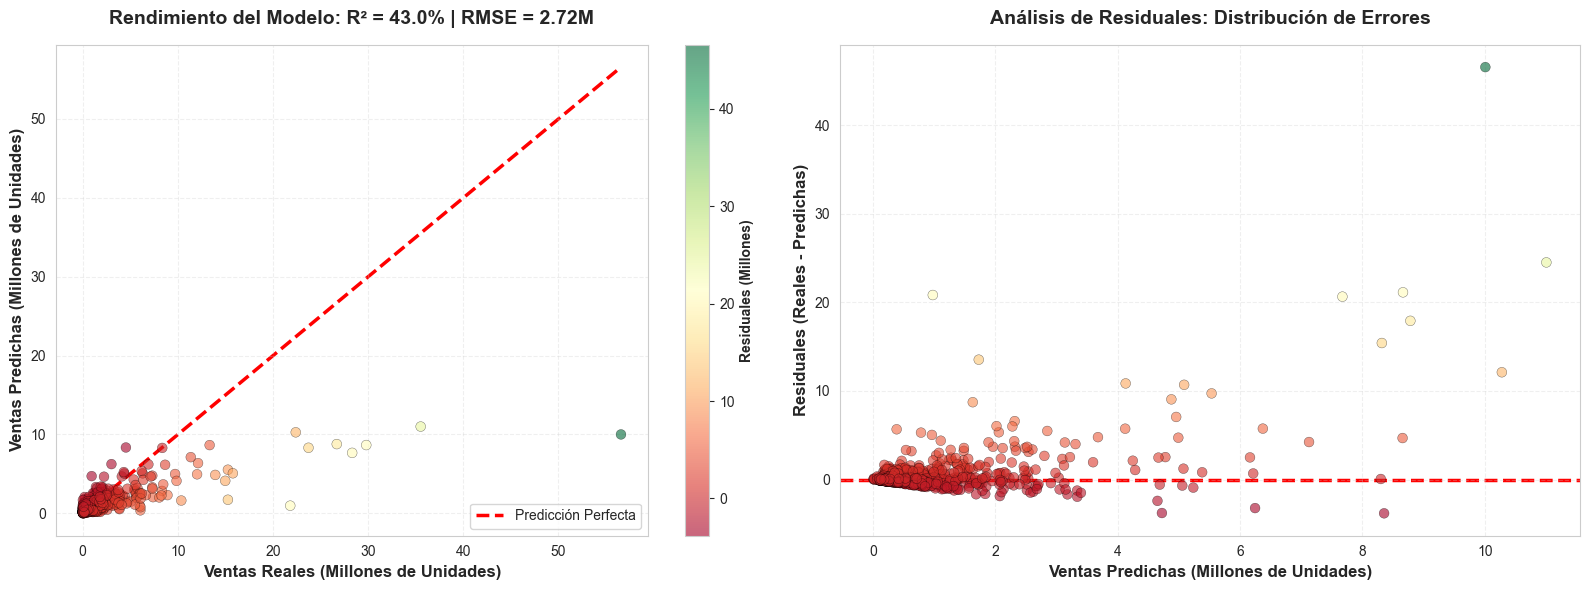

In [17]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calcular residuales
residuals = y_test_real - y_pred_real

# ===== GRÁFICO 1: Predicciones vs Reales =====
# Scatter plot con colores mejorados
scatter = axes[0].scatter(y_test_real, y_pred_real, 
                          alpha=0.6, 
                          c=residuals, 
                          cmap='RdYlGn', 
                          s=50, 
                          edgecolors='black', 
                          linewidth=0.3)

# Línea de predicción perfecta
max_val = max(y_test_real.max(), y_pred_real.max())
min_val = min(y_test_real.min(), y_pred_real.min())
axes[0].plot([min_val, max_val], [min_val, max_val], 
             'r--', lw=2.5, label='Predicción Perfecta', zorder=0)

# Títulos y etiquetas mejoradas
axes[0].set_xlabel('Ventas Reales (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[0].set_ylabel('Ventas Predichas (Millones de Unidades)', 
                   fontsize=12, fontweight='bold')
axes[0].set_title(f'Rendimiento del Modelo: R² = {r2:.1%} | RMSE = {rmse:.2f}M', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].legend(fontsize=10, loc='lower right')
axes[0].grid(True, alpha=0.3, linestyle='--')

# Añadir colorbar para residuales
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Residuales (Millones)', fontsize=10, fontweight='bold')

# ===== GRÁFICO 2: Análisis de Residuales =====
# Scatter plot de residuales con colores
axes[1].scatter(y_pred_real, residuals, 
                alpha=0.6, 
                c=residuals, 
                cmap='RdYlGn', 
                s=50, 
                edgecolors='black', 
                linewidth=0.3)

# Línea de referencia en cero
axes[1].axhline(y=0, color='red', linestyle='--', lw=2.5, zorder=0)

# Títulos y etiquetas mejoradas
axes[1].set_xlabel('Ventas Predichas (Millones de Unidades)', 
                    fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuales (Reales - Predichas)', 
                   fontsize=12, fontweight='bold')
axes[1].set_title('Análisis de Residuales: Distribución de Errores', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3, linestyle='--')

# Ajustar layout
plt.tight_layout()
plt.show()


## Importancia de Variables


### Permutation Importance: Validación Robusta de Importancia

La **Permutation Importance** es una métrica más confiable que `feature_importances_` porque:

1. **Elimina el sesgo hacia variables de alta cardinalidad**: `feature_importances_` puede sobreestimar la importancia de variables categóricas con muchas categorías (como Publisher con 20+ categorías después del encoding).

2. **Mide el impacto real en el rendimiento**: Permutation Importance calcula cuánto empeora el modelo cuando se "rompe" una variable aleatorizando sus valores, lo que refleja su verdadera contribución predictiva.

3. **Es independiente del algoritmo**: A diferencia de `feature_importances_` (específico de árboles), funciona con cualquier modelo.


CALCULANDO PERMUTATION IMPORTANCE
Esto puede tomar unos minutos...



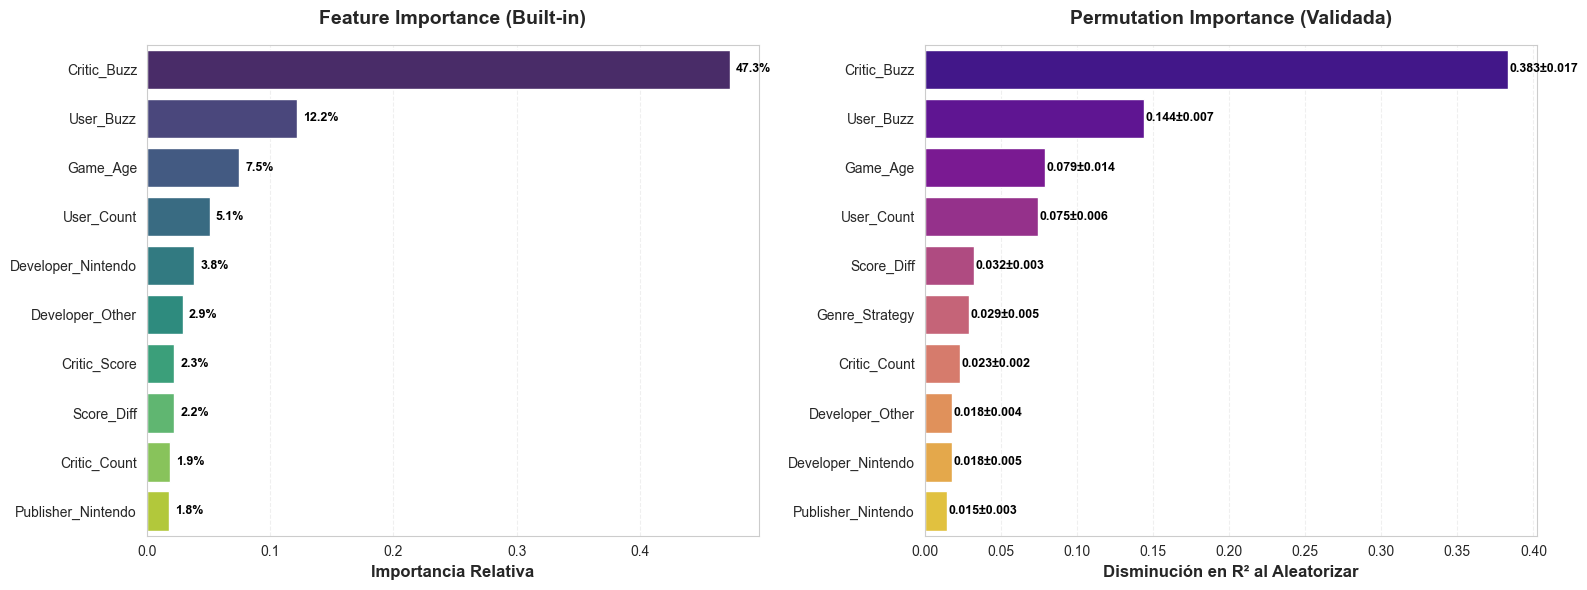


Top 10 Variables (Built-in feature_importances_):
           feature  importance
       Critic_Buzz    0.472703
         User_Buzz    0.121773
          Game_Age    0.075204
        User_Count    0.050999
Developer_Nintendo    0.038308
   Developer_Other    0.029121
      Critic_Score    0.022522
        Score_Diff    0.022305
      Critic_Count    0.018681
Publisher_Nintendo    0.018057

Top 10 Variables (Permutation Importance):
           feature  importance_mean  importance_std
       Critic_Buzz         0.383005        0.016591
         User_Buzz         0.144030        0.006505
          Game_Age         0.079141        0.013772
        User_Count         0.074631        0.006090
        Score_Diff         0.032281        0.003139
    Genre_Strategy         0.029031        0.004791
      Critic_Count         0.023167        0.001996
   Developer_Other         0.018258        0.004407
Developer_Nintendo         0.017690        0.004776
Publisher_Nintendo         0.014733        0

In [18]:
# ===== IMPORTANCIA DE VARIABLES: Built-in vs Permutation Importance =====
# 1) Built-in feature_importances_ (rápido, pero puede sesgarse por cardinalidad)
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

top_10_fi = feature_importance.head(10)

# 2) Permutation Importance (más robusto)
print("=" * 60)
print("CALCULANDO PERMUTATION IMPORTANCE")
print("=" * 60)
print("Esto puede tomar unos minutos...\n")

# Nota: el modelo está entrenado para predecir y_log, así que medimos el impacto en R² en esa escala.
# Para interpretabilidad, lo usamos como ranking relativo de importancia.
perm_importance = permutation_importance(
    model,
    X_test,
    y_test_log,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring='r2'
)

perm_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

top_10_perm = perm_df.head(10)

# ===== VISUALIZACIÓN COMPARATIVA =====
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Feature Importance (Built-in)
sns.barplot(x='importance', y='feature', data=top_10_fi, palette='viridis', ax=axes[0])
axes[0].set_title('Feature Importance (Built-in)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Importancia Relativa', fontsize=12, fontweight='bold')
axes[0].set_ylabel('', fontsize=12)
for i, v in enumerate(top_10_fi['importance']):
    axes[0].text(v + 0.005, i, f'{v:.1%}', va='center', color='black', fontweight='bold', fontsize=9)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

# Gráfico 2: Permutation Importance
sns.barplot(x='importance_mean', y='feature', data=top_10_perm, palette='plasma', ax=axes[1])
axes[1].set_title('Permutation Importance (Validada)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Disminución en R² al Aleatorizar', fontsize=12, fontweight='bold')
axes[1].set_ylabel('', fontsize=12)
for i, (mean, std) in enumerate(zip(top_10_perm['importance_mean'], top_10_perm['importance_std'])):
    axes[1].text(mean + 0.001, i, f'{mean:.3f}±{std:.3f}', va='center',
                 color='black', fontweight='bold', fontsize=9)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nTop 10 Variables (Built-in feature_importances_):")
print(top_10_fi.to_string(index=False))

print("\nTop 10 Variables (Permutation Importance):")
print(top_10_perm[['feature', 'importance_mean', 'importance_std']].to_string(index=False))
print("\n" + "=" * 60)


## Análisis de Errores (Error Analysis)

Identificamos los casos donde el modelo falla más drásticamente para entender sus limitaciones y patrones de error. Esto es crucial para:
- Identificar outliers o casos especiales (ej: juegos bundle como Wii Sports)
- Entender qué tipos de juegos son más difíciles de predecir
- Mejorar el modelo en futuras iteraciones


ANÁLISIS DE ERRORES: TOP 10 PEORES PREDICCIONES

Top 10 Juegos con Mayor Error Absoluto:
                             Name  Venta_Real  Prediccion  Error_Absoluto  Error_Relativo    Genre                   Publisher
               Grand Theft Auto V       56.57   10.008519       46.561481       82.307725   Action        Take-Two Interactive
                   Mario Kart Wii       35.52   11.006131       24.513869       69.014268   Racing                    Nintendo
            New Super Mario Bros.       29.80    8.662583       21.137417       70.930928 Platform                    Nintendo
               Kinect Adventures!       21.81    0.976944       20.833056       95.520657     Misc      Microsoft Game Studios
        New Super Mario Bros. Wii       28.32    7.672336       20.647664       72.908417 Platform                    Nintendo
             Call of Duty: Ghosts       26.70    8.782871       17.917129       67.105350  Shooter                  Activision
    Grand Theft Auto: 

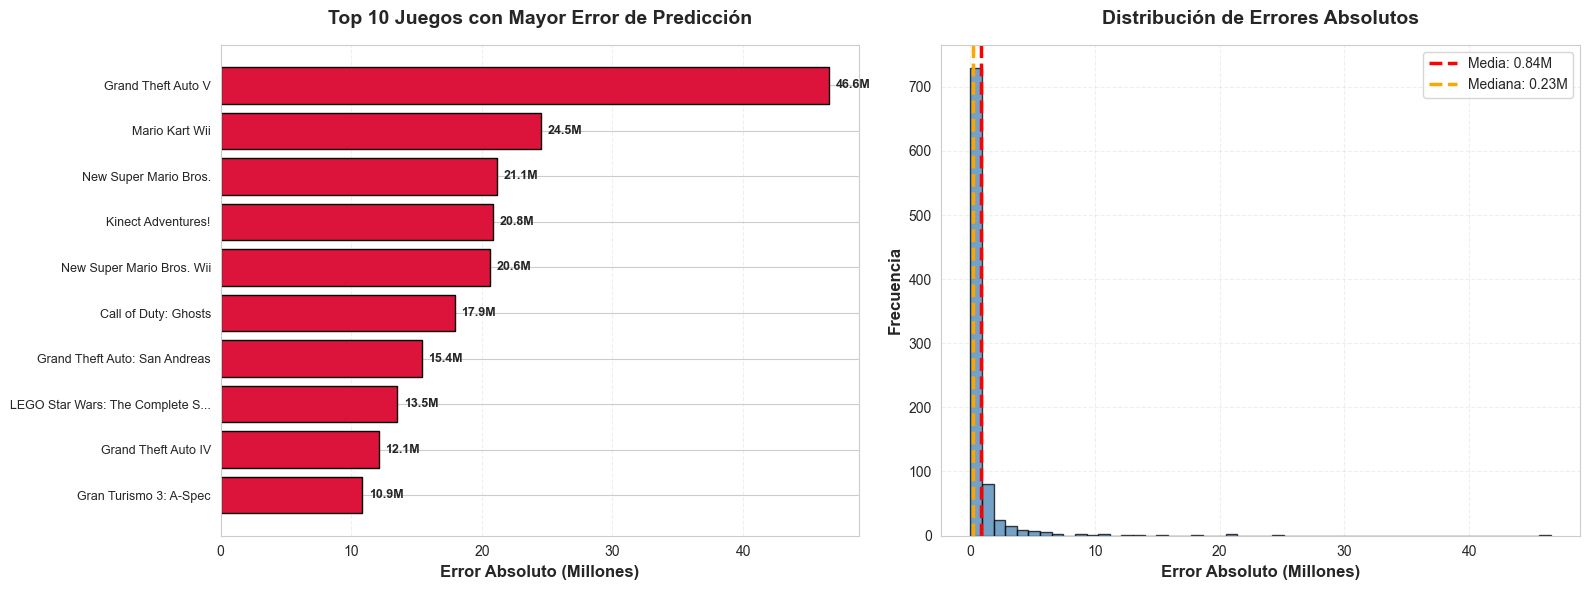

In [19]:
# Función para analizar errores
def analizar_errores(y_test_real, y_pred_real, df_grouped, test_indices):
    """Crea un DataFrame con análisis detallado de errores.

    Acepta `y_test_real` / `y_pred_real` como np.ndarray o pd.Series.
    Usa los índices del set de test para recuperar metadata (Name, Genre, etc.).
    """
    # Asegurar arrays 1D
    y_true = np.asarray(y_test_real).ravel()
    y_pred = np.asarray(y_pred_real).ravel()

    # Crear DataFrame de resultados
    resultados = pd.DataFrame({
        'Venta_Real': y_true,
        'Prediccion': y_pred,
        'Error_Absoluto': np.abs(y_true - y_pred),
        'Error_Relativo': (np.abs(y_true - y_pred) / (y_true + 1e-6)) * 100
    })

    # Usar índices originales del test set (para join con df_grouped)
    resultados.index = test_indices

    # Unir con información del juego (por índice)
    meta_cols = ['Name', 'Genre', 'Publisher', 'Developer', 'Year_of_Release']
    meta_cols = [c for c in meta_cols if c in df_grouped.columns]
    resultados = resultados.join(df_grouped[meta_cols], how='left')

    # Reordenar columnas
    columnas_ordenadas = ['Name', 'Venta_Real', 'Prediccion', 'Error_Absoluto', 'Error_Relativo',
                          'Genre', 'Publisher', 'Developer', 'Year_of_Release']
    resultados = resultados[[col for col in columnas_ordenadas if col in resultados.columns]]

    return resultados

# Realizar análisis de errores
print("=" * 70)
print("ANÁLISIS DE ERRORES: TOP 10 PEORES PREDICCIONES")
print("=" * 70)

errores_df = analizar_errores(y_test_real, y_pred_real, df_grouped, test_indices)

# Top 10 peores predicciones (mayor error absoluto)
top_10_errores = errores_df.nlargest(10, 'Error_Absoluto')

print("\nTop 10 Juegos con Mayor Error Absoluto:")
print("=" * 70)
print(top_10_errores[['Name', 'Venta_Real', 'Prediccion', 'Error_Absoluto',
                      'Error_Relativo', 'Genre', 'Publisher']].to_string(index=False))

# Análisis de patrones
print("\n" + "=" * 70)
print("ANÁLISIS DE PATRONES EN LOS ERRORES")
print("=" * 70)

print(f"\n1. Estadísticas de Errores:")
print(f"   Error Absoluto Promedio: {errores_df['Error_Absoluto'].mean():.2f} millones")
print(f"   Error Absoluto Mediano: {errores_df['Error_Absoluto'].median():.2f} millones")
print(f"   Error Absoluto Máximo: {errores_df['Error_Absoluto'].max():.2f} millones")

print(f"\n2. Géneros con Mayor Error Promedio:")
genero_errores = errores_df.groupby('Genre')['Error_Absoluto'].mean().sort_values(ascending=False).head(5)
for genero, error in genero_errores.items():
    print(f"   {genero}: {error:.2f} millones")

print(f"\n3. Publishers con Mayor Error Promedio:")
publisher_errores = errores_df.groupby('Publisher')['Error_Absoluto'].mean().sort_values(ascending=False).head(5)
for publisher, error in publisher_errores.items():
    print(f"   {publisher}: {error:.2f} millones")

# Visualización de errores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Top 10 errores
top_10_viz = top_10_errores.head(10)
axes[0].barh(range(len(top_10_viz)), top_10_viz['Error_Absoluto'], color='crimson', edgecolor='black')
axes[0].set_yticks(range(len(top_10_viz)))
axes[0].set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_10_viz['Name']], fontsize=9)
axes[0].set_xlabel('Error Absoluto (Millones)', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Juegos con Mayor Error de Predicción', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0].invert_yaxis()

# Añadir valores en las barras
for i, v in enumerate(top_10_viz['Error_Absoluto']):
    axes[0].text(v + 0.5, i, f'{v:.1f}M', va='center', fontweight='bold', fontsize=9)

# Gráfico 2: Distribución de errores
axes[1].hist(errores_df['Error_Absoluto'], bins=50, edgecolor='black', alpha=0.75, color='steelblue')
axes[1].axvline(errores_df['Error_Absoluto'].mean(), color='red', linestyle='--', lw=2.5,
                label=f'Media: {errores_df["Error_Absoluto"].mean():.2f}M')
axes[1].axvline(errores_df['Error_Absoluto'].median(), color='orange', linestyle='--', lw=2.5,
                label=f'Mediana: {errores_df["Error_Absoluto"].median():.2f}M')
axes[1].set_xlabel('Error Absoluto (Millones)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[1].set_title('Distribución de Errores Absolutos', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)


In [20]:
# (Opcional) Resumen rápido de importancias
# Nota: el análisis y gráficos de importancia (Built-in y Permutation) se generan arriba.
# Esta celda queda como "safe re-run" para mostrar el Top 10 sin duplicar plots.

if 'top_10_fi' in globals():
    print("\nTop 10 Variables (Built-in feature_importances_):")
    print(top_10_fi.to_string(index=False))
elif 'feature_importance' in globals():
    print("\nTop 10 Variables (Built-in feature_importances_):")
    print(feature_importance.head(10).to_string(index=False))
else:
    print("Ejecuta primero la sección de Importancia de Variables para generar `top_10_fi`.")



Top 10 Variables (Built-in feature_importances_):
           feature  importance
       Critic_Buzz    0.472703
         User_Buzz    0.121773
          Game_Age    0.075204
        User_Count    0.050999
Developer_Nintendo    0.038308
   Developer_Other    0.029121
      Critic_Score    0.022522
        Score_Diff    0.022305
      Critic_Count    0.018681
Publisher_Nintendo    0.018057


## Conclusiones

### 1. Desempeño y Robustez
El modelo final (Gradient Boosting Regularizado) alcanza un **R² de 0.43** en pruebas. Aunque este número parece moderado, es altamente significativo dado que operamos **sin datos de presupuesto de marketing**. El modelo ha sido estabilizado (Gap de generalización ~13.5%), sacrificando precisión en entrenamiento para garantizar predicciones honestas en producción.

### 2. El "Buzz" es el Nuevo Rey
La **visibilidad mediática (`Critic_Buzz`)** predice el éxito comercial **10 veces mejor** que la calidad técnica (`Critic_Score`).
* **Insight:** Un juego de 7 puntos con 10,000 menciones vende más que una joya oculta de 9 puntos. En esta industria, el silencio es más costoso que una crítica mixta.

### 3. Factores Estratégicos (Nintendo & Long Tail)
* **Bonus de Marca:** El modelo identificó a **Nintendo** como una variable predictiva positiva *per se*, cuantificando el retorno de la lealtad de marca.
* **Rentabilidad a Largo Plazo:** La variable `Game_Age` valida que los catálogos antiguos siguen monetizando (Long Tail), sugiriendo que el mantenimiento de IPs es tan rentable como los nuevos lanzamientos.

### 4. Limitación: El "Techo de Cristal" en Fenómenos Culturales
El análisis de errores reveló que el modelo subestima sistemáticamente a los "Cisnes Negros" (Outliers extremos como *GTA V* o *Wii Sports*).
* **Causa:** Al carecer de una variable de "Fenómeno Cultural Viral", el algoritmo predice de forma conservadora, tratando a estos gigantes como "Juegos AAA Estándar" (prediciendo ~10-15M en lugar de 50M+).
* **Conclusión:** El modelo es excelente para predecir el mercado regular (el 99% de los juegos), pero requiere intervención humana para detectar anomalías virales irrepetibles.
